In [60]:
# Bibliotecas
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision

import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
# Lendo os dados de treinamento e teste
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [62]:
# Verificando as informações do df de treinamento
print("Forma do datraframe :", df_train.shape)
print("Informação do dataframe : ")
df_train.info()
df_train.head()

Forma do datraframe : (209673, 8)
Informação do dataframe : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


In [63]:
# Verificando as imperfeições do df
print("Quantidade de Valores Nulos no dataframe de treinamento em cada coluna\n")
print(df_train.isna().sum())
print("\nQuantidade de valores duplicados:", df_train.duplicated().sum())

Quantidade de Valores Nulos no dataframe de treinamento em cada coluna

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

Quantidade de valores duplicados: 4325


In [64]:
# Apagando imperfeições - Tirando valores duplicados
df_train.drop_duplicates(inplace = True)
print("Dados pós-processamento :")
print("\nQuantidade de valores duplicados:", df_train.duplicated().sum())
print("Forma do datraframe :", df_train.shape)

Dados pós-processamento :

Quantidade de valores duplicados: 0
Forma do datraframe : (205348, 8)


In [65]:
# Detecção de valores discrepantes por IQR
def outlier_iqr (data, col):
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.90)
        IQR = q3- q1
        u_l = q3 + 1.5 * IQR
        l_l = q1 - 1.5 * IQR
        return (l_l, u_l)

In [66]:
# Excluindo valores rótulos
cols = df_train.columns.drop(["total_fare","surge_applied"])
cols

Index(['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare',
       'tip', 'miscellaneous_fees'],
      dtype='object')

In [67]:
# Verificando as discrepância
print("Discrepância :\n")
for col in cols:
    l_l , u_l = outlier_iqr(df_train,col)
    print(col," : ",((df_train[col]<l_l)| (df_train[col]> u_l)).sum())
    df_train[col] = df_train[col][~((df_train[col]<l_l)| (df_train[col]> u_l))]

Discrepância :

trip_duration  :  3208
distance_traveled  :  2552
num_of_passengers  :  9034
fare  :  2965
tip  :  1644
miscellaneous_fees  :  1244


In [68]:
print("Quantidade de Valores Nulos no dataframe de treinamento em cada coluna\n")
print(df_train.isna().sum())
df_train.dropna(inplace = True)
print("\nExcluindo valores Nulos")
print("Quantidade de Valores Nulos no dataframe de treinamento em cada coluna\n")
print(df_train.isna().sum())

Quantidade de Valores Nulos no dataframe de treinamento em cada coluna

trip_duration         3208
distance_traveled     2552
num_of_passengers     9034
fare                  2965
tip                   1644
miscellaneous_fees    1244
total_fare               0
surge_applied            0
dtype: int64

Excluindo valores Nulos
Quantidade de Valores Nulos no dataframe de treinamento em cada coluna

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64


<Axes: >

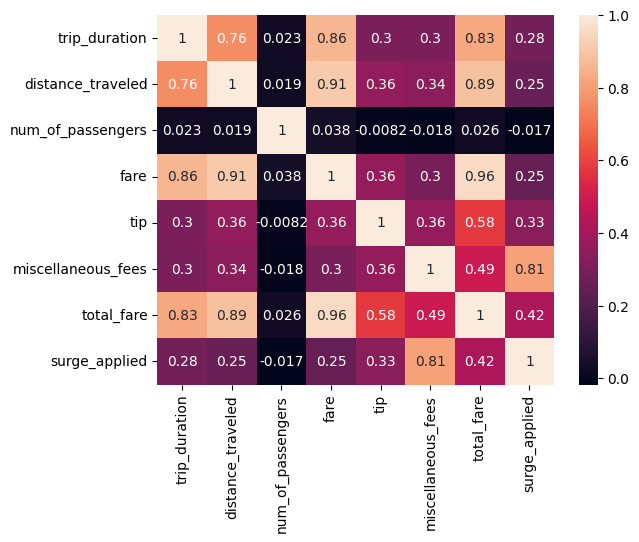

In [69]:
# Visualizando correlação das colunas
sns.heatmap(df_train.corr(), annot = True)

# Ideias após visualizar os dados
> total_fare e distance_traveled,total_fare e trip_duration são altamente correlacionados, mas a total_fare é alvo variável, portanto não pode ser descartada.
> distance_traveld e trip_duration são altamente correlacionados, então podemos descartar um deles.
> fare e total_fare são altamente correlacionadas, então diminua, temos que diminuir a tarifa.

<Axes: >

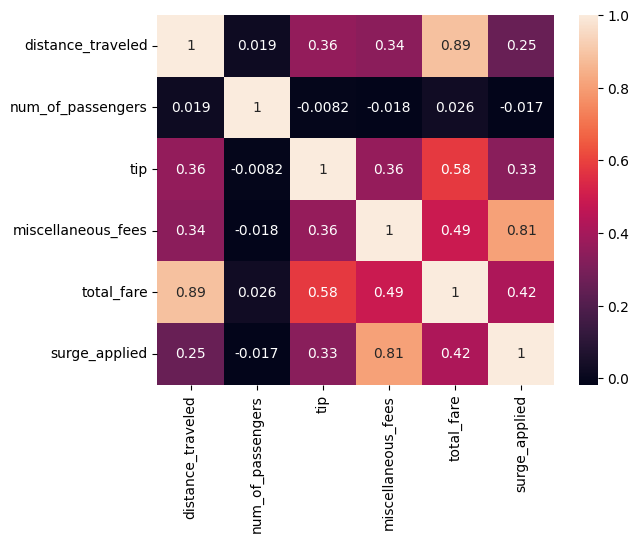

In [70]:
sns.heatmap(df_train.drop(columns =["fare","trip_duration"]).corr(), annot = True)

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
df1 = df_train
vif["variable"] = df1.columns
vif["VIF_Value"] = [variance_inflation_factor(df1,i) for i in range(df1.shape[1])]
vif

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variable,VIF_Value
0,trip_duration,13.220486
1,distance_traveled,14.225937
2,num_of_passengers,4.322407
3,fare,inf
4,tip,inf
5,miscellaneous_fees,inf
6,total_fare,inf
7,surge_applied,3.917220


In [72]:
df_train = df_train.drop(columns = ["trip_duration", "fare","tip","miscellaneous_fees"])
df_train

,distance_traveled,num_of_passengers,total_fare,surge_applied
0,2.75,1.0,105.300,0
1,3.43,1.0,142.200,0
2,3.12,1.0,97.875,1
3,5.63,3.0,99.750,0
4,2.09,1.0,70.200,0
...,...,...,...,...
209667,1.24,1.0,51.000,0
209668,8.42,1.0,202.800,0
209669,1.29,1.0,95.325,1
209670,2.82,1.0,69.750,0


In [73]:
# Separadando dados dos rótulos
X = df_train.drop("total_fare", axis = 1)
y = df_train["total_fare"]

In [74]:
from sklearn.preprocessing import StandardScaler
Scale = StandardScaler()
# surge_applied é uma variável categórica e já rotulada.
cols = X.drop("surge_applied", axis = 1).columns
X[cols] = Scale.fit_transform(X[cols])

In [75]:
X

,distance_traveled,num_of_passengers,surge_applied
0,-0.445894,-0.306333,0
1,-0.257041,-0.306333,0
2,-0.343136,-0.306333,1
3,0.353955,5.128726,0
4,-0.629193,-0.306333,0
...,...,...,...
209667,-0.865259,-0.306333,0
209668,1.128809,-0.306333,0
209669,-0.851373,-0.306333,1
209670,-0.426453,-0.306333,0


In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.20 ,random_state = 42)

In [89]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [90]:
y_pred = lr.predict(X_test)

In [91]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8241438496084479

[]

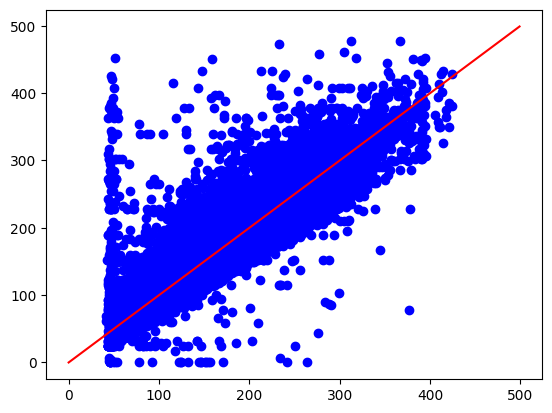

In [92]:
import numpy as np
plt.scatter(y_pred,y_test, c= "b")
plt.plot(np.arange(0,500),np.arange(0,500), c= "r")
plt.plot()